## Comparing relatedness of same/different polysemous senses

Using a [modified version](https://docs.google.com/spreadsheets/d/1bQGH6c0fSV6SW878RqsO2bTQgspxUZDnIzZysmjNjfQ/edit#gid=0) of the stimuli from Klepousniotou et al (2008), I will obtain contextualized embeddings for the target word, then compare these embeddings to those for targets occurring *within* vs. *across* sense boundaries. I will also ask whether relatedness scales with the amount of sense overlap.

In [1]:
import pandas as pd
import seaborn as sns

from scipy.spatial.distance import cosine
from tqdm import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

In [3]:
STIMULI_PATH = "../data/stims/stimuli.csv"

### Load data

In [33]:
df_stims = pd.read_csv(STIMULI_PATH)
df_stims.head(5)

,Source,String,Word,Class,Original Condition,M1_a,M1_b,M2_a,M2_b,Comments,K_relatedness
0,Klepousniotou et al (2008),lamb,lamb,N,high overlap,They liked the marinated lamb.,They liked the tender lamb.,They liked the baby lamb.,They liked the friendly lamb.,NaN,4.00
1,Klepousniotou et al (2008),article,article,N,high overlap,He read the history article.,He read the well-written article.,He read the popular article.,He read the submitted article.,NaN,4.45
2,Klepousniotou et al (2008),book,book,N,high overlap,He had the best-selling book.,He had the advertised book.,He had the heavy book.,He had the leather-bound book.,NaN,4.73
3,Klepousniotou et al (2008),breakfast,breakfast,N,high overlap,They ate a pancake breakfast.,They ate a nutritious breakfast.,They ate a family breakfast.,They ate a lonely breakfast.,"M2_b kind odd b/c of singular ""they""",4.45
4,Klepousniotou et al (2008),chicken,chicken,N,high overlap,They liked the juicy chicken.,They liked the roasted chicken.,They liked the clucking chicken.,They liked the young chicken.,NaN,4.14


In [34]:
# Remove any problematic stims with comments. Overly conservative.
df_filtered = df_stims[df_stims['Comments'].isna()].reset_index()
len(df_filtered)

91

In [35]:
# Remove rows for which we don't have all versions coded
df_filtered = df_stims[~df_stims['M1_b'].isna()].reset_index()
len(df_filtered)

114

In [36]:
df_filtered['Original Condition'].value_counts()

homonym             25
moderate overlap    23
low overlap         22
high overlap        22
distant             11
close               11
Name: Original Condition, dtype: int64

### Load ELMo

In [8]:
from allennlp.commands.elmo import ElmoEmbedder

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [9]:
elmo = ElmoEmbedder(
    options_file='https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway_5.5B/elmo_2x4096_512_2048cnn_2xhighway_5.5B_options.json', 
    weight_file='https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway_5.5B/elmo_2x4096_512_2048cnn_2xhighway_5.5B_weights.hdf5'
)

100%|██████████| 374434792/374434792 [00:43<00:00, 8579521.65B/s]


### Embed sentences

In [37]:
distances = []
with tqdm(total=len(df_filtered)) as progress_bar:
    for index, row in df_filtered.iterrows():

        # Extract condition, target word info, and mean relatedness
        condition = row['Original Condition']
        target_word = row['String']
        relatedness = row['K_relatedness']
        source = row['Source']
        
        # Extract and split sentences
        m1_a, m1_b = row['M1_a'].lower().replace(".", "").split(), row['M1_b'].lower().replace(".", "").split()
        m2_a, m2_b = row['M2_a'].lower().replace(".", "").split(), row['M2_b'].lower().replace(".", "").split()

        target_embeddings = {}
        for label, sentence in [('m1_a', m1_a), 
                                ('m1_b', m1_b), 
                                ('m2_a', m2_a),
                                ('m2_b', m2_b)]:
            target_index = sentence.index(target_word)
            target_embedding = elmo.embed_sentence(sentence)[2][target_index]
            target_embeddings[label] = target_embedding
        
        distances.append({
            'same': True,
            'word': target_word,
            'item': index,
            'condition': condition,
            'relatedness': relatedness,
            'version': 'M1',
            'source': source,
            'distance': cosine(target_embeddings['m1_a'], target_embeddings['m1_b'])
        })
        distances.append({
            'same': True,
            'word': target_word,
            'condition': condition,
            'relatedness': relatedness,
            'item': index,
            'version': 'M2',
            'source': source,
            'distance': cosine(target_embeddings['m2_a'], target_embeddings['m2_b'])
        })
        distances.append({
            'same': False,
            'word': target_word,
            'condition': condition,
            'relatedness': relatedness,
            'item': index,
            'version': 'M1A_M2A',
            'source': source,
            'distance': cosine(target_embeddings['m1_a'], target_embeddings['m2_a'])
        })
        distances.append({
            'same': False,
            'word': target_word,
            'condition': condition,
            'relatedness': relatedness,
            'item': index,
            'version': 'M1A_M2B',
            'source': source,
            'distance': cosine(target_embeddings['m1_a'], target_embeddings['m2_b'])
        })
        distances.append({
            'same': False,
            'word': target_word,
            'condition': condition,
            'relatedness': relatedness,
            'item': index,
            'source': source,
            'version': 'M1B_M2A',
            'distance': cosine(target_embeddings['m1_b'], target_embeddings['m2_a'])
        })
        distances.append({
            'same': False,
            'word': target_word,
            'condition': condition,
            'relatedness': relatedness,
            'item': index,
            'source': source,
            'version': 'M1B_M2B',
            'distance': cosine(target_embeddings['m1_b'], target_embeddings['m2_b'])
        })
        progress_bar.update(1)
        
        

100%|██████████| 114/114 [02:52<00:00,  1.36s/it]


In [39]:
df_distances = pd.DataFrame(distances)

In [40]:
df_distances.to_csv("../data/processed/stims_processed.csv")

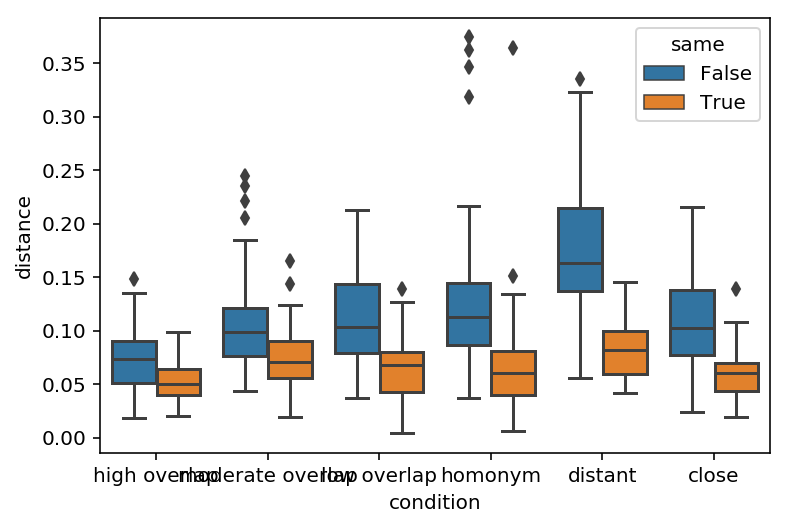

In [41]:
sns.boxplot(data = df_distances,
           x = 'condition',
           y = 'distance',
           hue = "same")